In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
from pandas.api.types import CategoricalDtype
from IPython.display import display

warnings.simplefilter('ignore')

df = pd.read_csv('train.csv')

In [3]:
plt.style.use('seaborn-whitegrid')
plt.rc('figure', autolayout = True)
plt.rc('axes', labelweight = 'bold', titlesize = 14, titlepad = 10)

In [4]:
#Some Typo in one of the feature
df.Exterior2nd.unique()

array(['VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng',
       'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'Brk Cmn', 'ImStucc',
       'AsphShn', 'Stone', 'Other', 'CBlock'], dtype=object)

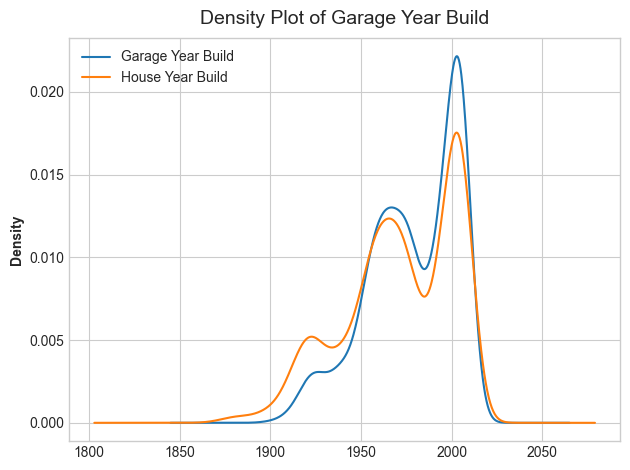

In [5]:
#Checking Corrupt data in the GarageYrBlt
df.GarageYrBlt.plot(kind = 'kde', title = 'Density Plot of Garage Year Build')
df.YearBuilt.plot(kind = 'kde')
plt.legend(['Garage Year Build', 'House Year Build'])

In [6]:
df[df['GarageYrBlt']>=2010.0]['GarageYrBlt']

378    2010.0
819    2010.0
987    2010.0
Name: GarageYrBlt, dtype: float64

In [7]:
df[df['YearBuilt']>=2010.0]['YearBuilt']

378    2010
Name: YearBuilt, dtype: int64

In [49]:
def clean(data):
    data['Exterior2nd'] = data['Exterior2nd'].replace({'Brk Cmn':'BrkComm', 'Wd Shng': 'WdShing', 'CmentBd':'CemntBd'})
    #Imputation some corrupt data in GarageYrBlt
    data['GarageYrBlt'] = data['GarageYrBlt'].where(data.GarageYrBlt<= 2010.0, data.YearBuilt)
    data.rename(columns = {'3SsnPorch':'ThreeseasonPorch'}, inplace = True)
    return data

In [9]:
len(df.select_dtypes(include = 'object').columns)

43

In [10]:
features_nom = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig", 
                "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", 
                "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", 
                "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", "SaleType", "SaleCondition"]

In [71]:
five_levels = ['Po','Fa','TA', 'Gd','Ex']
ten_levels = list(range(10))
ordered_lvl = { "OverallQual": ten_levels,
               "OverallCond": ten_levels,  "ExterQual": five_levels,
               "ExterCond": five_levels,"BsmtQual": five_levels,
               "BsmtCond": five_levels, "HeatingQC": five_levels,
               "KitchenQual": five_levels, "FireplaceQu": five_levels,
               "GarageQual": five_levels, "GarageCond": five_levels, 
               "PoolQC": five_levels, "LotShape": ["Reg", "IR1", "IR2", "IR3"],
               "LandSlope": ["Sev", "Mod", "Gtl"], "BsmtExposure": ["No", "Mn", "Av", "Gd"],
               "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
               "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
               "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
               "GarageFinish": ["Unf", "RFn", "Fin"],
               "PavedDrive": ["N", "P", "Y"],
               "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
               "CentralAir": ["N", "Y"],
               "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
               "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"]
              }

# Add None level for the missing value
ordred_lvl = {key: ['None'] + value for key, value in ordered_lvl.items()}

def encode(data):
    #Nominal categories
    for name in features_nom:
        data[name] = data[name].astype('category')
        # Add a None Category for the missing value
        if 'None' not in data[name].cat.categories:
            data[name] = data[name].cat.add_categories('None')
        
    for name, levels in ordered_lvl.items():
        data[name] = data[name].astype(CategoricalDtype(levels, ordered=True))
    return data

In [55]:
#Handle Missing value
def impute (data):
    for name in data.select_dtypes('number'):
        data[name] = data[name].fillna(0)
    for name in data.select_dtypes('category'):
        data[name] = data[name].fillna('None')
    return data

In [75]:
def load():
    #Import
    df_train = pd.read_csv('train.csv', index_col='Id')
    df_test = pd.read_csv('test.csv',  index_col = 'Id')
    # Merge data
    df = pd.concat((df_train.loc[:, 'MSSubClass':'SaleCondition'],df_test.loc[:,'MSSubClass':'SaleCondition']))
    #Preprocessing
    df_clean = clean(df)
    df_encode = encode(df_clean)
    df_imputation = impute(df_encode)
    # Reform
    train = df_imputation[:df_train.shape[0]]
    test = df_imputation[df_test.shape[0]:]
    y = df_train['SalePrice']
    return train, test, y

In [77]:
train, test,  label = load()

TypeError: Cannot setitem on a Categorical with a new category (None), set the categories first